# Tweets data wrangling
#### Imports

In [2]:
import pandas as pd
import numpy as np
import requests
import os
import yaml
import json
import pprint
import tweepy
import time

## Gather
### Twitter Archive

In [3]:
# Create twitter archive DataFrame from the associated csv file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Tweets image prediction

In [4]:
image_pred_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = image_pred_url.split('/')[-1]

if not os.path.isfile(file_name):
    # Retrieve the file content from the web
    response = requests.get(image_pred_url)
    # And save it in a tsv file
    with open(file_name, mode='wb') as file:
        file.write(response.content)
        
# Create tweet image prediction DataFrame from the downloaded tsv file
df_tweets_img_pred = pd.read_csv(file_name, sep='\t')
df_tweets_img_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Tweeter API

In [5]:
# Load the API keys from the yaml file
with open('twitter_api_keys.yaml', mode='r') as file:
    twitter_cred = yaml.load(file, Loader=yaml.FullLoader)
    
consumer_key = twitter_cred['APIKEY']
consumer_secret = twitter_cred['APIKEYSECRET']
access_token = twitter_cred['ACCESSTOKEN']
access_secret = twitter_cred['ACCESSTOKENSECRET']

# Open a tweepy API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

tweet_json_path = 'tweet_json.txt'
overwrite_json_file = False
if overwrite_json_file or not os.path.isfile(tweet_json_path):
    with open(tweet_json_path, 'w') as outfile:
        for idx, tweet_id in df_twitter_archive.tweet_id.iteritems():
            start_time = time.time()
            try:
                tweet_status = api.get_status(tweet_id, tweet_mode='extended')
                if idx > 0:
                    outfile.write("\n")
                json.dump(tweet_status._json, outfile)
                
                print("Tweet {} retrieved from Twitter API in {:.3f} seconds".format(tweet_id, time.time() - start_time))
            except tweepy.TweepError as e:
                print("Tweet {} couldn\'t be retrieved from Twitter API with error: \"{}\"".format(tweet_id, e))               

In [6]:
# Open the json txt file and extract the needed infos from the json data for each tweet saved
if os.path.isfile(tweet_json_path):
    with open(tweet_json_path, 'r') as json_file:
        # Create some columns for the new values retrieved from Twitter API
        df_twitter_archive['retweet_count'] = pd.Series(np.nan, dtype='Int64')
        df_twitter_archive['favorite_count'] = pd.Series(np.nan, dtype='Int64')
        
        # Iterate over each line in the txt file until the end of the file
        json_line = json_file.readline()
        while json_line:
            # Retrieve info from the json data structure
            tweet_json_data = json.loads(json_line)
            tweet_id = tweet_json_data['id']
            retweet_count = tweet_json_data['retweet_count']
            favorite_count = tweet_json_data['favorite_count']
            #print("Tweet {} has {} retweets and {} favorites".format(tweet_id,
            #                                                        retweet_count,
            #                                                        favorite_count))
            
            # And copy it in the Twitter archive DataFrame
            df_twitter_archive.loc[df_twitter_archive.tweet_id == tweet_id, 'retweet_count'] = retweet_count
            df_twitter_archive.loc[df_twitter_archive.tweet_id == tweet_id, 'favorite_count'] = favorite_count
            
            json_line = json_file.readline()

In [7]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## Assess
### Data Quality
#### df_twitter_archive

- source column should be a human readable category instead of non readable HTML code
- timestamp and retweeted_status_timestamp should be a DateTime instead of a string
- Some rating_numerator and rating_denominator don't follow the Dog Rates convention
- \*_status_id and \*_user_id should be int instead of float
- p1 (dog's race name) string should be formated the same way
- Many dogs have 'a' as name
- Some dogs have multiple dog stage (doggo, pupper or puppo)
- Some tweets have missing retweet_count and favorite_count
- There are less tweets rows in df_tweets_img_pred as in df_twitter_archive

#### df_tweets_img_pred


### Data tidiness

- doggo, flooter, pupper and puppo should be one categorical variable
- Dog race with highest probability and and dog flag variables from df_tweets_img_pred should be part of df_twitter_archive

In [8]:
df_twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
1407,699079609774645248,NaN,NaN,2016-02-15 03:55:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Reagan. He's a Persnicketus Derpson. Grea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699079609...,8,10,Reagan,None,None,None,None,622,2370
1915,674318007229923329,NaN,NaN,2015-12-08 20:01:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lennon. He's in quite the predicament....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674318007...,8,10,Lennon,None,None,pupper,None,483,1330
1786,677573743309385728,NaN,NaN,2015-12-17 19:39:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sandy. He's sexually confused. Thinks ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677573743...,10,10,Sandy,None,None,None,None,663,2041
278,840268004936019968,NaN,NaN,2017-03-10 18:27:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Monty. He makes instantly regrettable ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/840268004...,12,10,Monty,None,None,None,None,5514,18706
1470,694001791655137281,NaN,NaN,2016-02-01 03:38:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chester. He's a Benefloof Cumberbark. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/694001791...,11,10,Chester,None,None,None,None,986,3297
777,776088319444877312,NaN,NaN,2016-09-14 16:00:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can't tap the screen to make the hearts appe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776088319...,10,10,None,None,None,None,None,147,1808
1059,741743634094141440,NaN,NaN,2016-06-11 21:27:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Aqua. She's a sandy pupper. Not sure how ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/741743634...,11,10,Aqua,None,None,pupper,None,2644,7916
1715,680221482581123072,NaN,NaN,2015-12-25 03:00:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is CeCe. She's patiently waiting for Sant...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680221482...,10,10,CeCe,None,None,None,None,282,1425
1232,713175907180089344,NaN,NaN,2016-03-25 01:29:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Opie and Clarkus. Clarkus fell as...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713175907...,10,10,Opie,None,None,None,None,1417,4299
1356,703425003149250560,7.030419e+17,4.196984e+09,2016-02-27 03:42:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Really guys? Again? I know this is a rare Alba...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703425003...,9,10,None,None,None,None,None,1308,3682


In [9]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2331.000000,2331.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,2609.335049,7353.651652
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,4414.651029,11421.088202
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,1.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,529.000000,1277.500000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,1219.000000,3192.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,3028.500000,8999.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,74969.000000,151551.000000


In [11]:
df_twitter_archive.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
          ... 
Glenn        1
Samsom       1
Harvey       1
Evy          1
Perry        1
Name: name, Length: 957, dtype: int64

In [12]:
df_twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [13]:
df_twitter_archive[['doggo', 'pupper', 'puppo']].value_counts()

doggo  pupper  puppo
None   None    None     1985
       pupper  None      245
doggo  None    None       84
None   None    puppo      29
doggo  pupper  None       12
       None    puppo       1
dtype: int64

In [14]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [15]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [16]:
df_tweets_img_pred.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
259,670782429121134593,https://pbs.twimg.com/media/CU8ZDu9WwAADg3N.jpg,1,Chihuahua,0.952963,True,French_bulldog,0.036575,True,Boston_bull,0.001977,True
165,668979806671884288,https://pbs.twimg.com/media/CUixld6WoAArDrJ.jpg,1,golden_retriever,0.608537,True,Irish_setter,0.097078,True,redbone,0.076022,True
290,671166507850801152,https://pbs.twimg.com/media/CVB2TnWUYAA2pAU.jpg,1,refrigerator,0.829772,False,toilet_seat,0.030083,False,shower_curtain,0.015461,False
1882,847157206088847362,https://pbs.twimg.com/media/C8G0_CMWsAAjjAY.jpg,2,Staffordshire_bullterrier,0.219609,True,American_Staffordshire_terrier,0.178671,True,pug,0.123271,True
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
564,678255464182861824,https://pbs.twimg.com/media/CWmlvxJU4AEAqaN.jpg,1,Chihuahua,0.613819,True,Yorkshire_terrier,0.127931,True,Pomeranian,0.062124,True
1087,718939241951195136,https://pbs.twimg.com/media/CfovbK4WIAAkTn3.jpg,1,Pembroke,0.766327,True,Cardigan,0.222126,True,toilet_tissue,0.006757,False
1371,762316489655476224,https://pbs.twimg.com/media/CpRKzZKWAAABGh7.jpg,1,African_grey,0.270468,False,Madagascar_cat,0.076187,False,television,0.033306,False
1018,710117014656950272,https://pbs.twimg.com/media/CdrXp9dWoAAcRfn.jpg,2,toy_poodle,0.802092,True,miniature_poodle,0.111647,True,cocker_spaniel,0.062866,True
112,667911425562669056,https://pbs.twimg.com/media/CUTl5m1WUAAabZG.jpg,1,frilled_lizard,0.257695,False,ox,0.235160,False,triceratops,0.085317,False


In [17]:
df_tweets_img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
df_tweets_img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [19]:
df_tweets_img_pred.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
sandbar                 1
cup                     1
restaurant              1
Japanese_spaniel        1
nail                    1
Name: p1, Length: 378, dtype: int64

## Clean
### Save a copy of the original data

In [20]:
df_twitter_archive_clean = df_twitter_archive.copy()
df_tweets_img_pred_clean = df_tweets_img_pred.copy()

In [21]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Dog race with highest probability and and dog flag variables from df_tweets_img_pred should be part of df_twitter_archive
This also solve "There are less tweets rows in df_tweets_img_pred as in df_twitter_archive"
#### Define
Merge p1 and p1_dog df_tweets_img_pred_clean into df_twitter_archive_clean on the tweet_id column and rename the merged colums. Keep only the rows from the df_tweets_img_pred since there are less tweets in this DF as in df_twitter_archive. This way, each tweet will have a dog prediction.
#### Code

In [22]:
#df_twitter_archive_clean = df_twitter_archive.copy()
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_tweets_img_pred_clean[['tweet_id', 'p1', 'p1_dog']],
                                    on='tweet_id', how='right')
df_twitter_archive_clean.p1_dog = df_twitter_archive_clean.p1_dog.astype("boolean")
df_twitter_archive_clean.rename(columns={'p1': 'pred_dog_breed',
                                        'p1_dog': 'pred_is_dog'},
                               inplace=True)

#### Test

In [23]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   int64  
 11  rating_denominator          2075 non-null   int64  
 12  name                        2075 non-null   object 
 13  doggo                       2075 

### doggo, flooter, pupper and puppo should be one categorical variable 
Also solve "Some dogs have multiple dog stage (doggo, flooter, pupper or puppo)"
#### Define
Merge doggo, flooter, pupper and puppo should into one dog_stage categorical variable. If a dog is classified with multiple stage, give the priority to the older stage (doggo > pupper > puppo).
#### Code

In [24]:
#df_twitter_archive_clean = df_twitter_archive.copy()
df_twitter_archive_clean['dog_stage'] = np.nan

for index, row in df_twitter_archive_clean.iterrows():
    if row.doggo == 'doggo':
        df_twitter_archive_clean.loc[index, 'dog_stage'] = 'doggo'
    elif row.pupper == 'pupper':
        df_twitter_archive_clean.loc[index, 'dog_stage'] = 'pupper'
    elif row.puppo == 'puppo':
        df_twitter_archive_clean.loc[index, 'dog_stage'] = 'puppo'
        
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.astype('category')
df_twitter_archive_clean[['doggo', 'pupper', 'puppo', 'dog_stage']].sample(10)

,doggo,pupper,puppo,dog_stage
675,None,None,None,NaN
929,None,None,None,NaN
408,None,None,None,NaN
288,None,None,None,NaN
1424,None,None,None,NaN
1000,None,None,None,NaN
1744,None,None,puppo,puppo
1367,None,None,None,NaN
1670,None,None,None,NaN
379,None,None,None,NaN


In [25]:
df_twitter_archive_clean.drop(columns=['doggo', 'pupper', 'puppo'], inplace=True)

#### Test

In [26]:
df_twitter_archive_clean.dog_stage.value_counts()

pupper    211
doggo      80
puppo      23
Name: dog_stage, dtype: int64

In [27]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   tweet_id                    2075 non-null   int64   
 1   in_reply_to_status_id       23 non-null     float64 
 2   in_reply_to_user_id         23 non-null     float64 
 3   timestamp                   2075 non-null   object  
 4   source                      2075 non-null   object  
 5   text                        2075 non-null   object  
 6   retweeted_status_id         81 non-null     float64 
 7   retweeted_status_user_id    81 non-null     float64 
 8   retweeted_status_timestamp  81 non-null     object  
 9   expanded_urls               2075 non-null   object  
 10  rating_numerator            2075 non-null   int64   
 11  rating_denominator          2075 non-null   int64   
 12  name                        2075 non-null   object  
 13  floofer           

### Some tweets have missing retweet_count and favorite_count
#### Define
Since some counts are already equals or near 0, replace all the missing counts by 0

#### Code

In [28]:
df_twitter_archive_clean.retweet_count.fillna(0, inplace=True)
df_twitter_archive_clean.favorite_count.fillna(0, inplace=True)

#### Test

In [29]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   tweet_id                    2075 non-null   int64   
 1   in_reply_to_status_id       23 non-null     float64 
 2   in_reply_to_user_id         23 non-null     float64 
 3   timestamp                   2075 non-null   object  
 4   source                      2075 non-null   object  
 5   text                        2075 non-null   object  
 6   retweeted_status_id         81 non-null     float64 
 7   retweeted_status_user_id    81 non-null     float64 
 8   retweeted_status_timestamp  81 non-null     object  
 9   expanded_urls               2075 non-null   object  
 10  rating_numerator            2075 non-null   int64   
 11  rating_denominator          2075 non-null   int64   
 12  name                        2075 non-null   object  
 13  floofer           

In [30]:
df_twitter_archive_clean[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,2075.000000,2075.000000
mean,2475.830843,7705.850120
std,4348.555332,11711.884463
min,0.000000,0.000000
25%,523.500000,1434.500000
50%,1170.000000,3380.000000
75%,2850.500000,9556.000000
max,74969.000000,151551.000000


### Some rating_numerator and rating_denominator doesn't follow the Dog Rates convention
#### Define
For some inputs, correct manualy the denominator and numerator because there were not properly retrieved from the text.
For wrong, denominator, apply a ratio to the denominator and numerator to have the rating on 10.

#### Code denominator

In [31]:
#df_twitter_archive_clean = df_twitter_archive.copy()
pd.set_option("display.max_colwidth", 200)

df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
20,1,2,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
501,88,80,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw
560,144,120,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
667,7,11,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
692,121,110,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
693,143,130,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3"
865,44,40,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
941,60,50,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1007,45,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1025,80,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12


In [32]:
df_twitter_archive_clean.loc[20, ['rating_numerator', 'rating_denominator']] = [9, 10]
df_twitter_archive_clean.loc[667, ['rating_numerator', 'rating_denominator']] = [10, 10]
df_twitter_archive_clean.loc[1071, ['rating_numerator', 'rating_denominator']] = [11, 10]
df_twitter_archive_clean.loc[1105, ['rating_numerator', 'rating_denominator']] = [13, 10]
df_twitter_archive_clean.loc[1196, ['rating_numerator', 'rating_denominator']] = [14, 10]
df_twitter_archive_clean.loc[1658, ['rating_numerator', 'rating_denominator']] = [10, 10]
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
501,88,80,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw
560,144,120,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq
692,121,110,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
693,143,130,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3"
865,44,40,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
941,60,50,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1007,45,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1025,80,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1050,99,90,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1148,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv


In [33]:
def update_wrong_denomiator(tweet):
    if tweet.rating_denominator != 10:
        denominator_ratio = tweet.rating_denominator / 10
        return [int(tweet.rating_numerator / denominator_ratio), 10]
    else:
        #a = 1
        return [tweet.rating_numerator, tweet.rating_denominator]

wrong_denominator_idxs = df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10].index
df_twitter_archive_clean[['rating_numerator', 'rating_denominator']] = df_twitter_archive_clean.apply(update_wrong_denomiator, axis=1, result_type='expand')
df_twitter_archive_clean.loc[wrong_denominator_idxs, ['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
501,11,10
560,12,10
692,11,10
693,11,10
865,11,10
941,12,10
1007,9,10
1025,10,10
1050,11,10
1148,12,10


#### Test denominator

In [34]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text


#### Code numerator

In [35]:
df_twitter_archive_clean.rating_numerator.value_counts()

12      478
10      432
11      420
13      285
9       152
8        95
7        51
14       41
5        34
6        32
3        19
4        15
2         9
1         4
0         2
75        1
26        1
420       1
27        1
15        1
1776      1
Name: rating_numerator, dtype: int64

I will manualy enter the rounding of the rating given with decimal. It could be done programmaticaly using regex to extract the float from the text, but for 3 inputs, it is not worth the programming effort.

In [36]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator > 14][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
277,420,10,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
621,26,10,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
1270,1776,10,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1459,27,10,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
1515,75,10,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"
1844,15,10,RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI


In [37]:
df_twitter_archive_clean.loc[621, 'rating_numerator'] = 11
df_twitter_archive_clean.loc[1459, 'rating_numerator'] = 11
df_twitter_archive_clean.loc[1515, 'rating_numerator'] = 10

#### Test numerator

In [38]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator > 15][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
277,420,10,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
1270,1776,10,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh


We still have 2 outliers for the rating.
### Some names are missing ('None') or just 'a'
#### Define
From all tweets having 'a' as name, retrieve, when existing, the name of the dog situated after 'named' or 'name is' in the text using a regular expression.
Other tweets having 'a' as name don't have any given name in the text so replace 'a' by 'None'

#### Code

In [39]:
df_twitter_archive_clean[df_twitter_archive_clean.name == 'a'][['name', 'text']]

,name,text
1,a,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI
2,a,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR
3,a,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx
5,a,This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe
7,a,Here is a Siberian heavily armored polar bear mix. Strong owner. 10/10 I would do unspeakable things to pet this dog https://t.co/rdivxLiqEt
8,a,My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O
21,a,This is a funny dog. Weird toes. Won't come down. Loves branch. Refuses to eat his food. Hard to cuddle with. 3/10 https://t.co/IIXis0zta0
28,a,This is a southern Vesuvius bumblegruff. Can drive a truck (wow). Made friends with 5 other nifty dogs (neat). 7/10 https://t.co/LopTBkKa8h
41,a,This is a golden Buckminsterfullerene named Johm. Drives trucks. Lumberjack (?). Enjoys wall. 8/10 would hug softly https://t.co/uQbZJM2DQB
44,a,This is a purebred Bacardi named Octaviath. Can shoot spaghetti out of mouth. 10/10 https://t.co/uEvsGLOFHa


In [40]:
temp_dog_names = df_twitter_archive_clean[df_twitter_archive_clean.name == 'a']['text'].str.extract('(named|name is)\s(\w+)')[1]
temp_dog_names = temp_dog_names[~temp_dog_names.isna()]
df_twitter_archive_clean.loc[temp_dog_names.index, 'name'] = temp_dog_names
df_twitter_archive_clean.name.value_counts()

None       578
a           35
Charlie     11
Oliver      10
Lucy        10
          ... 
Darby        1
Biden        1
Bobby        1
Barclay      1
Johm         1
Name: name, Length: 953, dtype: int64

In [41]:
dog_named_a_idxs = df_twitter_archive_clean[df_twitter_archive_clean.name == 'a'].index
df_twitter_archive_clean.loc[dog_named_a_idxs, 'name'] = 'None'
df_twitter_archive_clean.name.value_counts()

None       613
Charlie     11
Oliver      10
Lucy        10
Tucker      10
          ... 
Darby        1
Biden        1
Bobby        1
Barclay      1
Molly        1
Name: name, Length: 952, dtype: int64

#### Test

In [42]:
df_twitter_archive_clean[df_twitter_archive_clean.name == 'a'][['name', 'text']]

,name,text


### timestamp and retweeted_status_timestamp should be a DateTime instead of a string
#### Define
Change the colums type from string to DateTime
#### Code

In [43]:
df_twitter_archive_clean.timestamp = pd.to_datetime(df_twitter_archive_clean.timestamp)
df_twitter_archive_clean.retweeted_status_timestamp = pd.to_datetime(df_twitter_archive_clean.retweeted_status_timestamp)

#### Test

In [44]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   int64              
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   object             
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     float64            
 7   retweeted_status_user_id    81 non-null     float64            
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

### \*_status_id and \*_user_id should be int instead of float
#### Define
Change the concerned columns type from float to int
#### Code

In [45]:
df_twitter_archive_clean.in_reply_to_status_id = df_twitter_archive_clean.in_reply_to_status_id.astype('Int64')
df_twitter_archive_clean.in_reply_to_user_id = df_twitter_archive_clean.in_reply_to_user_id.astype('Int64')
df_twitter_archive_clean.retweeted_status_id = df_twitter_archive_clean.retweeted_status_id.astype('Int64')
df_twitter_archive_clean.retweeted_status_user_id = df_twitter_archive_clean.retweeted_status_user_id.astype('Int64')

#### Test

In [46]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   int64              
 1   in_reply_to_status_id       23 non-null     Int64              
 2   in_reply_to_user_id         23 non-null     Int64              
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   object             
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     Int64              
 7   retweeted_status_user_id    81 non-null     Int64              
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

### source column should be a human readable category instead of non readable HTML code
#### Define
Extract the content of the HTML tags instead of the complete HTML code and transform it into a category
#### Code

In [47]:
df_twitter_archive_clean.source = df_twitter_archive_clean.source.str.extract('^<a href=.*>(.+)</a>$')
df_twitter_archive_clean.source = df_twitter_archive_clean.source.str.replace('- ', '')
df_twitter_archive_clean.source = pd.Categorical(df_twitter_archive_clean.source)
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone    2034
Twitter Web Client      30
TweetDeck               11
Name: source, dtype: int64

We can notice that the Vine source disapeared after the merge with the prediction table.
#### Test

In [48]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   int64              
 1   in_reply_to_status_id       23 non-null     Int64              
 2   in_reply_to_user_id         23 non-null     Int64              
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   category           
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     Int64              
 7   retweeted_status_user_id    81 non-null     Int64              
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

### p1 (dog's race name) string should be formated the same way
#### Define
Format the pred_dog_breed in order to have the same format for each breed
#### Code

In [49]:
df_twitter_archive_clean.pred_dog_breed.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
sandbar                 1
cup                     1
restaurant              1
Japanese_spaniel        1
nail                    1
Name: pred_dog_breed, Length: 378, dtype: int64

In [50]:
df_twitter_archive_clean.pred_dog_breed = df_twitter_archive_clean.pred_dog_breed.str.replace('_', ' ').str.title()

#### Test

In [51]:
df_twitter_archive_clean.pred_dog_breed.value_counts()

Golden Retriever      150
Labrador Retriever    100
Pembroke               89
Chihuahua              83
Pug                    57
                     ... 
Minibus                 1
Lacewing                1
Bison                   1
Beaver                  1
Slug                    1
Name: pred_dog_breed, Length: 378, dtype: int64

## Store cleaned data

In [52]:
df_twitter_archive_clean.to_csv('twitter_archive_master.csv')

## Analyze
### Predicted dogs

In [66]:
df_twitter_archive_dogs_only = df_twitter_archive_clean[df_twitter_archive_clean.pred_is_dog]
dogs_ratio = df_twitter_archive_dogs_only.shape[0] / df_twitter_archive_clean.shape[0]
print("There are {:.1f}% of the tweets that were predicted as representing a dog".format(dogs_ratio * 100))

There are 73.8% of the tweets that were predicted as representing a dog


### Rating analysis

In [53]:
df_twitter_archive_clean.rating_numerator.describe()

count    2075.000000
mean       11.654940
std        39.838615
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

With all the tweets, the rating mean is 10.65/10, the standard deviation is 39.83 and the median is 10/10

Let's remove the outliers

In [55]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator <= 15].rating_numerator.describe()

count    2073.000000
mean       10.606850
std         2.168191
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        15.000000
Name: rating_numerator, dtype: float64

Without the outliers, the rating mean is 10.60/10, the standard deviation drops to 2.16 (makes more sense) and the median is 10/10

Let's analyze the ratins only the tweets detected as dogs

In [60]:
df_twitter_archive_dogs_only.rating_numerator.describe()

count    1532.000000
mean       10.958225
std         1.682764
min         2.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

With only predicted dogs, the rating mean is 10.95/10, the standard deviation is 1.68 and the median is 10/10 and the outliers are not there anymore.
### Retweet and favorite counts analysis
Let's analyze the predicted dogs only

In [61]:
df_twitter_archive_dogs_only[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,1532.000000,1532.000000
mean,2483.627937,8014.703655
std,4417.849933,12038.438310
min,0.000000,0.000000
25%,551.500000,1628.500000
50%,1251.000000,3687.500000
75%,2896.750000,9972.250000
max,74969.000000,151551.000000


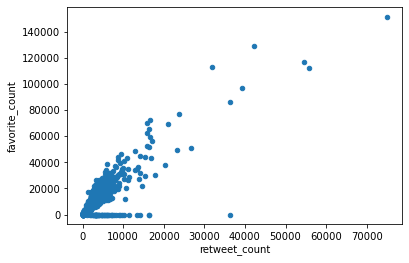

In [63]:
df_twitter_archive_dogs_only.plot.scatter(x='retweet_count', y='favorite_count');

We can notice that there is a correlation between the number of favorite and the number of retweet.
### Dog stages

In [72]:
dogs_with_stage = df_twitter_archive_dogs_only[~df_twitter_archive_dogs_only.dog_stage.isna()]
dog_stage_ratio = dogs_with_stage.shape[0] / df_twitter_archive_dogs_only.shape[0]
print("There are {:.1f}% of the tweets, predicted as dogs, were the user gave the stage of his dog.".format(dog_stage_ratio * 100))

There are 15.0% of the tweets, predicted as dogs, were the user gave the stage of his dog


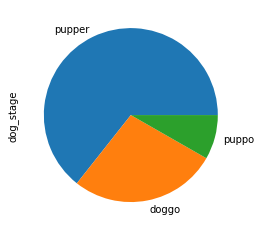

In [85]:
dogs_with_stage.dog_stage.value_counts().plot.pie();

Out of those dog with a given stage, we can notice that there are mostly some Puppers.